#Creazione classe dataset

In [ ]:
import torch
import numpy as np
import pandas as pd
import fiona
import os
import cv2

!pip install rasterio
!pip install geopandas
!pip install matplotlib

import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt


from google.colab import drive
drive.mount('/content/drive', force_remount=True)
percorso =  "/content/drive/MyDrive/Progetto_laboratorio"


In [ ]:
from torch.utils.data import Dataset
import json
from shapely.geometry import shape,mapping
from shapely.affinity import scale
from rasterio.enums import Resampling
from rasterio.features import rasterize
from datetime import datetime
import re
import torch.nn.functional as F
from PIL import Image

class Dataset(Dataset):
    def __init__(self, root, transform=None, patch_size=256, is_train=True):
        self.root = root
        self.transform = transform
        self.patch_size = patch_size
        self.is_train = is_train
        self.zones = self.load_zones()
        self.patches = self.generate_patches()

    def load_zones(self):
        zones = {}
        for zone in os.listdir(self.root):
            zone_path = os.path.join(self.root, zone)
            if os.path.isdir(zone_path):
                zones[zone] = self.load_images_and_labels(zone_path)
        return zones

    def load_images_and_labels(self, zone_path):
        image_label_pairs = []
        images_dir = os.path.join(zone_path, 'images_masked')
        labels_dir = os.path.join(zone_path, 'labels_match')
        if os.path.exists(images_dir) and os.path.exists(labels_dir):
            for image_file in os.listdir(images_dir):
                if image_file.endswith('.tif'):
                    image_path = os.path.join(images_dir, image_file)
                    label_file = os.path.splitext(image_file)[0] + '_Buildings.geojson'
                    label_path = os.path.join(labels_dir, label_file)
                    if os.path.exists(label_path):
                        date_str = re.search(r'\d{4}_\d{2}', image_file).group()
                        date = datetime.strptime(date_str, '%Y_%m')
                        image_label_pairs.append((image_path, label_path, date))
        image_label_pairs.sort(key=lambda x: x[2])
        return [(image_path, label_path) for image_path, label_path, date in image_label_pairs]

    def generate_images_masks(self,image_path1,image_path2,label_path1,label_path2):
        with rasterio.open(image_path1) as src1, rasterio.open(image_path2) as src2:
                image1 = src1.read().astype(np.float32)[:3, :, :]
                image2 = src2.read().astype(np.float32)[:3, :, :]
                out_shape = (src1.height, src1.width)

                if image1.shape[1:] != (1024, 1024):
                    image1 = self._resize_image(image1.transpose(1, 2, 0)).transpose(2, 0, 1)
                    out_shape = (image1.shape[1], image1.shape[2])
                if image2.shape[1:] != (1024, 1024):
                    image2 = self._resize_image(image2.transpose(1, 2, 0)).transpose(2, 0, 1)
                out_shape = (image2.shape[1], image2.shape[2])


                with open(label_path1) as label1, open(label_path2) as label2:
                    geojson1 = json.load(label1)
                    geojson2 = json.load(label2)


                mask1 = self.create_mask(geojson1, out_shape, src1.transform)
                mask2 = self.create_mask(geojson2, out_shape, src2.transform)


                image1_tensor = torch.from_numpy(image1)
                image2_tensor = torch.from_numpy(image2)
                if (image1_tensor.shape[0] != 3 and image1_tensor.shape[2] == 3):
                    image1_tensor = image1_tensor.permute(2,1,0)
                if (image2_tensor.shape[0] != 3 and image2_tensor.shape[2] == 3):
                    image2_tensor = image2_tensor.permute(2,1,0)
                if (image1_tensor.shape[0] != 3 and image1_tensor.shape[1] == 3):
                    image1_tensor = image1_tensor.permute(1,2,0)
                if (image2_tensor.shape[0] != 3 and image2_tensor.shape[1] == 3):
                    image2_tensor = image2_tensor.permute(1,2,0)
                images = torch.cat([image1_tensor, image2_tensor], dim=0)

                if not isinstance(mask1,np.ndarray):
                    mask1 = mask1.numpy()
                    #print(np.sum(mask1==1))
                if not isinstance(mask2,np.ndarray):
                    mask2 = mask2.numpy()
                    #print(np.sum(mask2==1))

                mask1_tensor = torch.from_numpy(mask1)
                mask2_tensor = torch.from_numpy(mask2)
                masks = torch.logical_xor(mask1_tensor, mask2_tensor).to(torch.uint8).numpy()

                if (images.shape[0] != 6 and images.shape[2]==6):
                    images.permute(2,1,0)
                if (images.shape[0] != 6 and images.shape[1]==6):
                    images.permute(1,2,0)

                image_patches, mask_patches = self.divide_into_patches(images, masks, self.patch_size)
                #patches.extend(zip(image_patches, mask_patches))

        return image_patches,mask_patches


    def generate_patches(self):
        patches = []


        for zone in self.zones.keys():
            selected_pairs = set()  # Per tenere traccia delle coppie già selezionate
            num_images = len(self.zones[zone])
            indices = list(range(num_images))

            while len(selected_pairs) < (num_images // 2)-2:  # Assicurati di non selezionare più coppie di quante possibili
                i = random.choice(indices)
                max_interval = num_images - i - 1  # Numero massimo di mesi successivi disponibili
                if max_interval == 0:
                    continue  # Se non ci sono immagini successive disponibili, salta

                interval = random.randint(1, max_interval)
                j = i + interval
                #print(i,j)
                if (i, j) not in selected_pairs:
                    selected_pairs.add((i, j))
                    image_path1, label_path1 = self.zones[zone][i]
                    image_path2, label_path2 = self.zones[zone][j]

                    images_patches, mask_patches = self.generate_images_masks(image_path1, image_path2, label_path1, label_path2)
                    patches.extend(zip(images_patches, mask_patches))

        return patches

    def __len__(self):
        return len(self.patches)

    def _resize_image(self, image, target_size=(1024, 1024)):
        return cv2.resize(image, target_size, interpolation=cv2.INTER_LINEAR)

    def divide_into_patches(self, image, mask, patch_size,no_change_prob=0.3):
        patches = []
        mask_patches = []
        _, h, w = image.shape
        for i in range(0, h, patch_size):
            for j in range(0, w, patch_size):
                image_patch = image[:, i:i+patch_size, j:j+patch_size]
                mask_patch = mask[i:i+patch_size, j:j+patch_size]
                if image_patch.shape[1] == patch_size and image_patch.shape[2] == patch_size:
                    if np.sum(mask_patch == 1) > 0 or (self.is_train and random.random() < no_change_prob) or not self.is_train:
                        patches.append(image_patch)
                        mask_patches.append(mask_patch)
        return patches, mask_patches

    def __getitem__(self, idx):
        image_patch, mask_patch = self.patches[idx]


        if self.transform:

            if (image_patch.shape[0] != 6 and image_patch.shape[2]==6):
                image_patch.permute(2,1,0)
            if (image_patch.shape[0] != 6 and image_patch.shape[1]==6):
                image_patch.permute(1,2,0)

            if not isinstance(image_patch, np.ndarray):
                image_patch = image_patch.numpy()

            if not isinstance(mask_patch, np.ndarray):
                mask_patch = mask_patch.numpy()

            augmented = self.transform(image=np.transpose(image_patch, (1, 2, 0)), mask=mask_patch)
            image_patch = np.transpose(augmented['image'], (2, 1, 0))
            mask_patch = augmented['mask']

        return image_patch, mask_patch

    def create_mask(self, geojson, out_shape, transform):
        if 'features' in geojson and len(geojson['features']) > 0:
            gdf = gpd.GeoDataFrame.from_features(geojson['features'])
            if not gdf.empty and gdf.geometry.notnull().any():
                mask = rasterize([(geom, 1) for geom in gdf.geometry], out_shape=out_shape, transform=transform, fill=0, dtype='uint8')
            else:
                mask = np.zeros(out_shape, dtype='uint8')
        else:
            mask = np.zeros(out_shape, dtype='uint8')
        return mask
    def add_patches(self, patches):
        self.patches.extend(patches)

In [ ]:
train_transform_aug = A.Compose([
    A.Rotate(limit=35, p=1.0),               # Ruota l'immagine di un angolo casuale tra -35 e 35 gradi con probabilità del 100%
    A.HorizontalFlip(p=0.5),                 # Esegue un flip orizzontale dell'immagine con probabilità del 50%
    A.VerticalFlip(p=0.1),                   # Esegue un flip verticale dell'immagine con probabilità del 10%
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.5),  # Trasla, scala e ruota l'immagine con probabilità del 50%
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),   # Modifica casualmente la luminosità e il contrasto con probabilità del 50%
    A.Normalize(
        mean=[0.4822, 0.4194, 0.3123],                # Normalizza l'immagine impostando la media dei canali a 0
        std=[0.1306, 0.1058, 0.0937],                 # Normalizza l'immagine impostando la deviazione standard dei canali a 1
        max_pixel_value=255.0,               # Imposta il valore massimo dei pixel a 255
    ),
    ToTensorV2(),                            # Converte l'immagine in un tensore PyTorch
], is_check_shapes=False)                    # Disabilita il controllo delle forme#train_dataset = Dataset("/content/drive/MyDrive/Progetto_laboratorio/Dataset/train")
test_dataset = Dataset("/content/drive/MyDrive/Progetto_laboratorio/Dataset/test",trasform=train_trasform_aug)
#val_dataset = Dataset("/content/drive/MyDrive/Progetto_laboratorio/Dataset/validation")

#key = next(iter(test_dataset.zones))
#print(test_dataset.zones)
#for zone in train_dataset.zones:
  #dataset_train_raster[zone] = train_dataset[zone]
#for zone in test_dataset.zones:
  #dataset_test_raster[zone] = test_dataset[zone]
#for zone in val_dataset.zones:
  #dataset_val_raster[zone] = val_dataset[zone]

NameError: name 'A' is not defined

In [ ]:
import matplotlib.pyplot as plt

def show_sample(images, masks):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(images[:3].permute(1, 2, 0).numpy().astype(np.int32))  # Prima immagine
    ax[1].imshow(images[3:].permute(1, 2, 0).numpy().astype(np.int32))  # Seconda immagine
    ax[2].imshow(torch.from_numpy(masks), cmap='gray')  # Maschera
    plt.show()

# Ottieni un campione dal dataset
images, masks = test_dataset[250]
show_sample(images, masks)

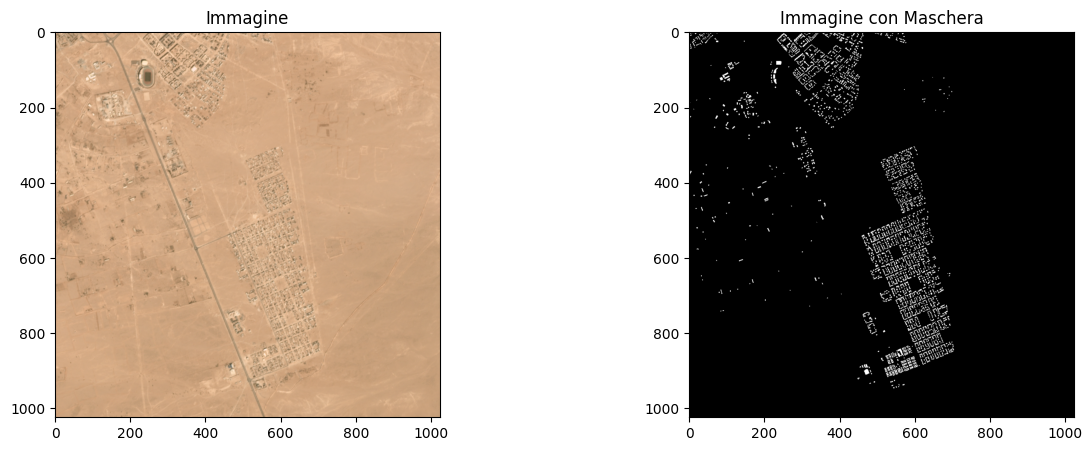

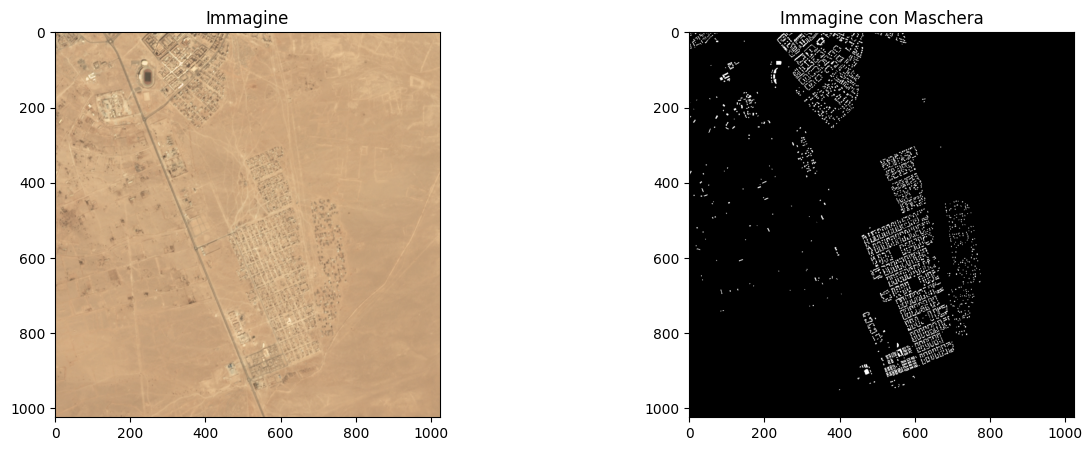

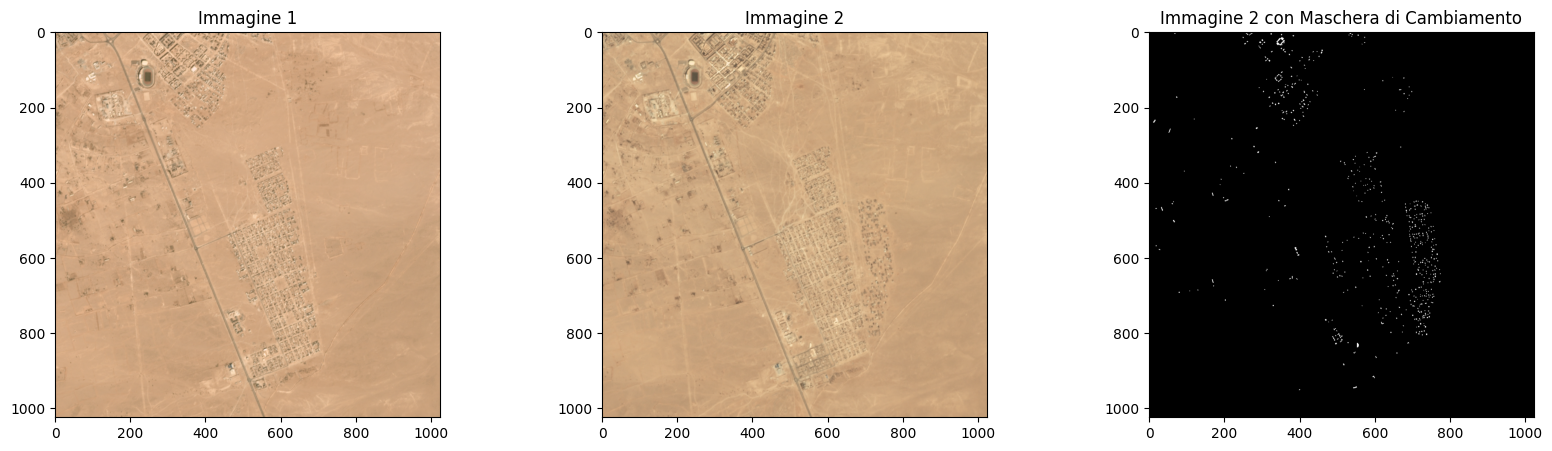

In [ ]:
def create_mask(geojson, out_shape, transform):
    if 'features' in geojson and len(geojson['features']) > 0:
        gdf = gpd.GeoDataFrame.from_features(geojson['features'])
        gdf = gdf[gdf.is_valid]  # Filtra geometrie non valide
        if not gdf.empty and gdf.geometry.notnull().any():
            mask = rasterize([(geom, 1) for geom in gdf.geometry], out_shape=out_shape, transform=transform, fill=0, dtype='uint8')
        else:
            mask = np.zeros(out_shape, dtype='uint8')
    else:
        mask = np.zeros(out_shape, dtype='uint8')
    return mask

def visualize_image_with_mask(image_path, label_path):
    # Carica l'immagine
    with rasterio.open(image_path) as src:
        image = src.read([1, 2, 3])  # Legge le prime tre bande per la visualizzazione
        transform = src.transform
        out_shape = (src.height, src.width)

    # Carica il GeoJSON
    with open(label_path) as f:
        geojson = json.load(f)

    # Crea la maschera
    mask = create_mask(geojson, out_shape, transform)

    # Crea una figura
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    # Mostra l'immagine
    ax[0].imshow(image.transpose(1, 2, 0))
    ax[0].set_title('Immagine')

    # Mostra la maschera sovrapposta all'immagine
    ax[1].imshow(image.transpose(1, 2, 0))
    ax[1].imshow(mask, cmap='gray', alpha=1)  # Sovrappone la maschera con trasparenza
    ax[1].set_title('Immagine con Maschera')

    plt.show()

def visualize_change_detection(image_path1, image_path2, label_path1, label_path2):
    # Carica le immagini
    with rasterio.open(image_path1) as src1, rasterio.open(image_path2) as src2:
        image1 = src1.read([1, 2, 3])  # Legge le prime tre bande per la visualizzazione
        image2 = src2.read([1, 2, 3])
        transform1 = src1.transform
        transform2 = src2.transform
        out_shape1 = (src1.height, src1.width)
        out_shape2 = (src2.height, src2.width)

    # Carica i GeoJSON
    with open(label_path1) as f1, open(label_path2) as f2:
        geojson1 = json.load(f1)
        geojson2 = json.load(f2)

    # Crea le maschere
    mask1 = create_mask(geojson1, out_shape1, transform1)
    mask2 = create_mask(geojson2, out_shape2, transform2)

    # Calcola la maschera di cambiamento
    change_mask = np.logical_xor(mask1, mask2).astype(np.uint8)

    # Crea una figura
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))

    # Mostra la prima immagine
    ax[0].imshow(image1.transpose(1, 2, 0))
    ax[0].set_title('Immagine 1')

    # Mostra la seconda immagine
    ax[1].imshow(image2.transpose(1, 2, 0))
    ax[1].set_title('Immagine 2')

    # Mostra la maschera di cambiamento sovrapposta alla seconda immagine
    ax[2].imshow(image2.transpose(1, 2, 0))
    ax[2].imshow(change_mask, cmap='gray', alpha=1)  # Sovrappone la maschera con trasparenza
    ax[2].set_title('Immagine 2 con Maschera di Cambiamento')

    plt.show()

image_path1=percorso+'/Dataset/validation/L15-0977E-1187N_3911_3441_13/images_masked/global_monthly_2018_01_mosaic_L15-0977E-1187N_3911_3441_13.tif'
label_path1=percorso+'/Dataset/validation/L15-0977E-1187N_3911_3441_13/labels_match/global_monthly_2018_01_mosaic_L15-0977E-1187N_3911_3441_13_Buildings.geojson'
image_path2=percorso+'/Dataset/validation/L15-0977E-1187N_3911_3441_13/images_masked/global_monthly_2019_11_mosaic_L15-0977E-1187N_3911_3441_13.tif'
label_path2=percorso+'/Dataset/validation/L15-0977E-1187N_3911_3441_13/labels_match/global_monthly_2019_11_mosaic_L15-0977E-1187N_3911_3441_13_Buildings.geojson'
visualize_image_with_mask(image_path1, label_path1)
visualize_image_with_mask(image_path2, label_path2)
visualize_change_detection(image_path1,image_path2,label_path1, label_path2)

In [ ]:
import matplotlib.pyplot as plt

def plot_patches_and_mask(data):
    concatenated_patch = data['concatenated_patch']
    mask = data['mask']

    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    axes[0].imshow(patch1)
    axes[0].set_title('Patch 1')
    axes[0].axis('off')

    axes[1].imshow(patch2)
    axes[1].set_title('Patch 2')
    axes[1].axis('off')

    axes[2].imshow(concatenated_patch)
    axes[2].set_title('Concatenated Patch')
    axes[2].axis('off')

    axes[3].imshow(mask, cmap='gray')
    axes[3].set_title('Mask')
    axes[3].axis('off')

    plt.show()

# Esempio di utilizzo
data = {
    'patch1': ... ,  # Inserisci qui la tua patch1
    'patch2': ... ,  # Inserisci qui la tua patch2
    'concatenated_patch': ... ,  # Inserisci qui la tua patch concatenata
    'mask': ...  # Inserisci qui la tua maschera
}

plot_patches_and_mask(test_dataset[0])


TypeError: tuple indices must be integers or slices, not str

In [ ]:
for zone in range(0,len(train_dataset)):
  train_dataset[zone]
for zone in range(0,len(val_dataset)):
  val_dataset[zone]
for zone in range(0,len(test_dataset)):
  test_dataset[zone]

CRSError: Missing src_crs.